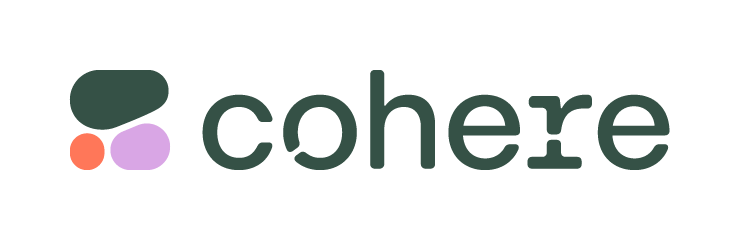

# Notebook Overview

## Motivation
Asking questions over documents continues to be an important retrieval augmented generation (RAG) task. However, the document complexity can significantly influence overall RAG performance, particularly when the documents are PDFs that contain a mix of text and tables. Finding an optimal strategy to parse this information, chunk, embed and retrieve it is thus quite critical to obtaining accurate results. Furthermore, if the questions being asked over the retrieved documents require mathematical reasoning, then having a model that can validate those operations is quite useful.

## Objective
In this notebook we will guide you through the best practices of setting up a RAG pipeline to process documents that contain both tables and text. In addition, we will show you how to create a Cohere ReAct agent with access to a RAG pipeline tool to improve accuracy. The general structure of the nb is as follows:

1. individual components around parsing, retrieval and generation are covered for documents with mixed tabular and textual data
2. a class object is created that can be used to instantiate the pipeline with parametric input
3. the RAG pipeline is then used as a tool for a cohere react agent

# Reference Documents
we recommend the following as a guide on doing [semi-structured RAG](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_Structured_RAG.ipynb)

we recommend this notebook to explore various parsing techniques for [PDFs](https://github.com/cohere-ai/notebooks/blob/main/notebooks/guides/Document_Parsing_For_Enterprises.ipynb)

various langchain supported [parsers](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf/)

## Table of Contents
- Section 1
    - [Parsing](#sec_step1)
    - [Vector Store Setup](#sec_step2)
    - [RAG Pipeline](#sec_step3)
- Section 2
    - [RAG Pipeline Class](#sec_step4)
- Section 3
    - [ReAct Agent with RAG Tool](#sec_step5)

## Install Dependencies

In [ ]:
# there may be other dependencies that will need installation
# ! pip install --quiet langchain langchain_cohere langchain_experimental
# !pip --quiet install faiss-cpu tiktoken
# !pip install pypdf
# !pip install pytesseract
# !pip install opencv-python --upgrade
# !pip install "unstructured[all-docs]"
# !pip install chromadb

In [2]:
# LLM
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_cohere import CohereEmbeddings
from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf
from langchain_community.document_loaders import PyPDFLoader
import os
from typing import Any
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
import cohere, json
import pandas as pd
from datasets import load_dataset
from joblib import Parallel, delayed


os.environ['COHERE_API_KEY'] = "lXjZMEFhvl2NSWoa7V4oQToSUubWk2BoQc2jNcca"

<a id="sec_step1"></a>
# Parsing

To improve RAG performance on PDFs with mixed types (text and tables), we investigated a number of parsing and chunking strategies from various libraries:
- PyPDFLoader (LC)
- LlamaParse (Llama-Index)
- Unstructured IO


We have found that the best option for parsing is unstructured.io since the parser can:
- separate tables from text
- automatically chunk the tables and text by title during the parsing step so that similar elements are grouped


In [3]:
# UNSTRUCTURED pdf loader
# Get elements
raw_pdf_elements = partition_pdf(
    filename="city_ny_popular_fin_report.pdf",
    # Unstructured first finds embedded image blocks
    extract_images_in_pdf=False,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path='.',
)


This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [4]:
# extract table and textual objects from parser
class Element(BaseModel):
    type: str
    text: Any

# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

14
24


<a id="sec_step2"></a>
# Vector Store Setup

There are many options to setup a vector store. Here we show how to set one up using Chroma and Langchains Multi-vector retrieval.
We use multi-vector retrieval because oftentimes a summary may be able to distill more accurately what a chunk is about, leading to better retrieval.

You can read more about this here: https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector/

The process is as follows:
- summaries of each chunk are embedded
- during inference, the multi-vector retrieval returns the full context document related to the summary

In [5]:

co = cohere.Client()

def get_chat_output(message, preamble, chat_history, model, temp, documents=None):
    return co.chat(
    message=message,
    preamble=preamble,
    chat_history=chat_history,
    documents=documents,
    model=model,
    temperature=temp
    ).text

def parallel_proc_chat(prompts,preamble,chat_history=None,model='command-r-plus',temp=0.1,n_jobs=10):
    """Parallel processing of chat endpoint calls."""
    responses = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(get_chat_output)(prompt,preamble,chat_history,model,temp) for prompt in prompts)
    return responses

def rerank_cohere(query, returned_documents,model:str="rerank-multilingual-v3.0",top_n:int=3):
    response = co.rerank(
        query=query,
        documents=returned_documents,
        top_n=top_n,
        model=model,
        return_documents=True
    )
    top_chunks_after_rerank = [results.document.text for results in response.results]
    return top_chunks_after_rerank


In [7]:
# generate table and text summaries

prompt_text = """You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. Table or text chunk: {element}. Only provide the summary and no other text."""

table_prompts = [prompt_text.format(element=i.text) for i in table_elements]
table_summaries = parallel_proc_chat(table_prompts,None)
text_prompts = [prompt_text.format(element=i.text) for i in text_elements]
text_summaries = parallel_proc_chat(text_prompts,None)
tables = [i.text for i in table_elements]
texts = [i.text for i in text_elements]

In [8]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=CohereEmbeddings())
# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))
# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

<a id="sec_step3"></a>
# RAG Pipeline

the query process can be broken down into the following steps:

1. augment the query, this really helps retrieve all the relevant information
2. use each augmented query to retrieve the top k docs and then rerank them
3. concatenate all the shortlisted/reranked docs and pass them to the generation model

In [9]:
def process_query(query, retriever):
    """Runs query augmentation, retrieval, rerank and final generation in one call."""
    augmented_queries=co.chat(message=query,model='command-r-plus',temperature=0.2, search_queries_only=True)
        #augment queries
    if augmented_queries.search_queries:
        reranked_docs=[]
        for itm in augmented_queries.search_queries:
            docs=retriever.invoke(itm.text)
            temp_rerank = rerank_cohere(itm.text,docs)
            reranked_docs.extend(temp_rerank)
        documents = [{"title": f"chunk {i}", "snippet": reranked_docs[i]} for i in range(len(reranked_docs))]
    else:
        #no queries will be run through RAG
        documents = None
    
    preamble = """
## Task & Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You should focus on serving the user's needs as best you can, which will be wide-ranging.

## Style Guide
Unless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.
"""
    model = 'command-r-plus'
    temp = 0.2

    
    
    response = co.chat(
      message=query,
      documents=documents,
      preamble=preamble,
      model=model,
      temperature=temp
    )

    final_answer_docs="""The final answer is from the documents below:
    
    {docs}""".format(docs=str(response.documents))

    final_answer = response.text
    return final_answer, final_answer_docs

## Example 

In [10]:
query = "what are the charges for services in 2022"
final_answer, final_answer_docs = process_query(query, retriever)
print(final_answer)
print(final_answer_docs)


chat_history=[{'role':"USER", 'message':query},{'role':"CHATBOT", 'message':f'The final answer is: {final_answer}.' + final_answer_docs}]
    

The charges for services in 2022 were $5,266 million.
The final answer is from the documents below:
    
    [{'id': 'doc_0', 'snippet': 'Program and General Revenues FY 2023 FY 2022 FY 2021 Category (in millions) Charges for Services (CS) $5,769 $5,266 $5,669 Operating Grants and Contributions (OGC) 27,935 31,757 28,109 Capital Grants and Contributions (CGC) 657 656 675 Real Estate Taxes (RET) 31,502 29,507 31,421 Sales and Use Taxes (SUT) 10,577 10,106 7,614 Personal Income Taxes (PIT) 15,313 15,520 15,795 Income Taxes, Other (ITO) 13,181 9,521 9,499 Other Taxes* (OT) 3,680 3,777 2,755 Investment Income* (II) 694 151 226 Unrestricted Federal and State Aid (UFSA) 234 549 108 Other* (O) Total Program and General Revenues - Primary Government 2,305 $110,250 $107,535 $104,176 708 725', 'title': 'chunk 0'}]


the final answer is correct based on page 12 in the PDF and we can see that the information retrieved is linked to that table :) 

### chat history management

an example of asking a follow up question that relies on the chat history but does not require a re-run of RAG.

The search_queries_only flag can be used to determine whether RAG needs to be rerun or not i.e. it can help easily identify if the query passed needs retrieval.

In the example below, the else statement is invoked based on query2. In the else we pass in history without documents as the new query does not need to call the RAG pipeline 

In [12]:
query2='divide this by two'
augmented_queries=co.chat(message=query2,model='command-r-plus',temperature=0.2, search_queries_only=True)
if augmented_queries.search_queries:
    print('RAG is needed')
    final_answer, final_answer_docs = process_query(query, retriever)
    print(final_answer)
else:
    print('RAG is not needed')
    response = co.chat(
      message=query2,
      model='command-r-plus',
      chat_history=chat_history,
      temperature=0.3
    )
    
    print("Final answer:")
    print(response.text)

RAG is not needed
Final answer:
The result of dividing the charges for services in 2022 by two is $2,633.


## ------------------------------------------------------- ##

<a id="sec_step4"></a>
# RAG Pipeline Class

Here we connect all the pieces discussed above into one class object that is then used as a tool for a cohere react agent. This class is to help consolidate and clarify the key parameters used to define the RAG pipeline.

In [13]:
co = cohere.Client()

In [19]:
class Element(BaseModel):
    type: str
    text: Any
    
class RAG_pipeline():
    def __init__(self,paths):
        self.embedding_model="embed-english-v3.0"
        self.generation_model="command-r-plus"
        self.summary_model="command-r-plus"
        self.rerank_model="rerank-multilingual-v3.0"
        self.num_docs_to_retrieve = 10
        self.top_k_rerank=3
        self.temperature=0.2
        self.preamble="""
## Task & Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You should focus on serving the user's needs as best you can, which will be wide-ranging.

## Style Guide
Unless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.
"""     
        self.n_jobs=10 #number of parallel processes to run summarization of chunks
        self.extract_images_in_pdf=False
        self.infer_table_structure=True
        self.chunking_strategy="by_title"
        self.max_characters=4000
        self.new_after_n_chars=3800
        self.combine_text_under_n_chars=2000
        self.image_output_dir_path='.'
        self.paths = paths
        self.parse_and_build_retriever()
        
    def parse_and_build_retriever(self,):
        #step1, parse pdfs
        # if condition just for debugging since perf_audit.pdf is parsed in the prev step, no need to rerun
        parsed_pdf_list=self.parse_pdfs(self.paths)
        #separate tables and text
        extracted_tables, extracted_text = self.extract_text_and_tables(parsed_pdf_list)
        #generate summaries for everything
        tables, table_summaries, texts, text_summaries=self.generate_summaries(extracted_tables,extracted_text)
        self.tables = tables
        self.table_summaries = table_summaries
        self.texts = texts
        self.text_summaries=text_summaries
        #setup the multivector retriever
        self.make_retriever(tables, table_summaries, texts, text_summaries)
        
    def extract_text_and_tables(self,parsed_pdf_list):
        # extract table and textual objects from parser
        # Categorize by type
        all_table_elements = []
        all_text_elements = []
        for raw_pdf_elements in parsed_pdf_list:
            categorized_elements = []
            for element in raw_pdf_elements:
                if "unstructured.documents.elements.Table" in str(type(element)):
                    categorized_elements.append(Element(type="table", text=str(element)))
                elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
                    categorized_elements.append(Element(type="text", text=str(element)))
            
            # Tables
            table_elements = [e for e in categorized_elements if e.type == "table"]
            print(len(table_elements))
            
            # Text
            text_elements = [e for e in categorized_elements if e.type == "text"]
            print(len(text_elements))
            all_table_elements.extend(table_elements)
            all_text_elements.extend(text_elements)

        return all_table_elements, all_text_elements
            
    def parse_pdfs(self, paths):

        path_raw_elements = []
        for path in paths:
            raw_pdf_elements = partition_pdf(
            filename=path,
            # Unstructured first finds embedded image blocks
            extract_images_in_pdf=self.extract_images_in_pdf,
            # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
            # Titles are any sub-section of the document
            infer_table_structure=self.infer_table_structure,
            # Post processing to aggregate text once we have the title
            chunking_strategy=self.chunking_strategy,
            # Chunking params to aggregate text blocks
            # Attempt to create a new chunk 3800 chars
            # Attempt to keep chunks > 2000 chars
            max_characters=self.max_characters,
            new_after_n_chars=self.new_after_n_chars,
            combine_text_under_n_chars=self.combine_text_under_n_chars,
            image_output_dir_path=self.image_output_dir_path,
            )
            path_raw_elements.append(raw_pdf_elements)
        print('PDFs parsed')
        return path_raw_elements
        

    def get_chat_output(self,message, preamble, model, temp):
        # print("**message")
        # print(message)
        
        response=co.chat(
            message=message,
            preamble=preamble,
            model=model,
            temperature=temp
            ).text
        # print("**output")
        # print(response)
        return response

    def parallel_proc_chat(self,prompts,preamble,model,temp,n_jobs):
        """Parallel processing of chat endpoint calls."""
        responses = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(self.get_chat_output)(prompt,preamble,model,temp) for prompt in prompts)
        return responses
    
    def rerank_cohere(self,query, returned_documents,model, top_n):
        response = co.rerank(
            query=query,
            documents=returned_documents,
            top_n=top_n,
            model=model,
            return_documents=True
        )
        top_chunks_after_rerank = [results.document.text for results in response.results]
        return top_chunks_after_rerank

    def generate_summaries(self,table_elements,text_elements):
        # generate table and text summaries

        summarize_prompt = """You are an assistant tasked with summarizing tables and text. \ 
        Give a concise summary of the table or text. Table or text chunk: {element}. Only provide the summary and no other text."""
        
        table_prompts = [summarize_prompt.format(element=i.text) for i in table_elements]
        table_summaries = self.parallel_proc_chat(table_prompts,self.preamble,self.summary_model,self.temperature,self.n_jobs)
        text_prompts = [summarize_prompt.format(element=i.text) for i in text_elements]
        text_summaries = self.parallel_proc_chat(text_prompts,self.preamble,self.summary_model,self.temperature,self.n_jobs)
        tables = [i.text for i in table_elements]
        texts = [i.text for i in text_elements]
        print('summaries generated')
        return tables, table_summaries, texts, text_summaries

    def make_retriever(self,tables, table_summaries, texts, text_summaries):
        # The vectorstore to use to index the child chunks
        vectorstore = Chroma(collection_name="summaries", embedding_function=CohereEmbeddings())
        # The storage layer for the parent documents
        store = InMemoryStore()
        id_key = "doc_id"
        # The retriever (empty to start)
        retriever = MultiVectorRetriever(
            vectorstore=vectorstore,
            docstore=store,
            id_key=id_key,
            search_kwargs={"k": self.num_docs_to_retrieve}
        )
        # Add texts
        doc_ids = [f'text_{i}' for i in range(len(texts))]#[str(uuid.uuid4()) for _ in texts]
        summary_texts = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(text_summaries)
        ]
        retriever.vectorstore.add_documents(summary_texts,ids=doc_ids)
        retriever.docstore.mset(list(zip(doc_ids, texts)))
        # Add tables
        table_ids = [f'table_{i}' for i in range(len(texts))]#[str(uuid.uuid4()) for _ in tables]
        summary_tables = [
            Document(page_content=s, metadata={id_key: table_ids[i]})
            for i, s in enumerate(table_summaries)
        ]
        retriever.vectorstore.add_documents(summary_tables,ids=table_ids)
        retriever.docstore.mset(list(zip(table_ids, tables)))
        self.retriever = retriever
        print('retriever built')
        
    def process_query(self,query):
        """Runs query augmentation, retrieval, rerank and generation in one call."""
        augmented_queries=co.chat(message=query,model=self.generation_model,temperature=self.temperature, search_queries_only=True)
        #augment queries
        if augmented_queries.search_queries:
            reranked_docs=[]
            for itm in augmented_queries.search_queries:
                docs=self.retriever.invoke(itm.text)
                temp_rerank = self.rerank_cohere(itm.text,docs,model=self.rerank_model,top_n=self.top_k_rerank)
                reranked_docs.extend(temp_rerank)
            documents = [{"title": f"chunk {i}", "snippet": reranked_docs[i]} for i in range(len(reranked_docs))]
        else:
            documents = None
            
        response = co.chat(
          message=query,
          documents=documents,
          preamble=self.preamble,
          model=self.generation_model,
          temperature=self.temperature
        )
    
        final_answer_docs="""The final answer is from the documents below:
        
        {docs}""".format(docs=str(response.documents))
    
        final_answer = response.text
        return final_answer, final_answer_docs


In [20]:
rag_object=RAG_pipeline(paths=["city_ny_popular_fin_report.pdf"])

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name


PDFs parsed
14
24
summaries generated
retriever built


<a id="sec_step5"></a>
# Cohere REACT Agent with RAG Tool

we build a simple agent using the RAG pipeline previously defined. The e2e rag pipeline is provided as a tool in addition to a python tool. The premise in coupling these tools is so that the mathematical steps can be done using a python tool to improve accuracy.

In [21]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_cohere.chat_models import ChatCohere
from langchain.tools.retriever import create_retriever_tool
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool

class react_agent():
    def __init__(self,rag_retriever,model="command-r-plus",temperature=0.2):
        self.llm = ChatCohere(model=model, temperature=temperature)
        self.preamble="""
## Task & Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You should focus on serving the user's needs as best you can, which will be wide-ranging.

## Style Guide
Unless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.

## Guidelines
You are an expert who answers the user's question. 
You have access to a vectorsearch tool that will use your query to search through documents and find the relevant answer.
You also have access to a python interpreter tool which you can use to run code for mathematical operations.
"""
        self.get_tools(rag_retriever)
        self.build_agent()
        
    def get_tools(self,rag_retriever):
        @tool
        def vectorsearch(query: str):
            """Uses the query to search through a list of documents and return the most relevant documents as well as the answer."""
            final_answer, final_answer_docs=rag_retriever.process_query(query)
            return final_answer + final_answer_docs
        vectorsearch.name = "vectorsearch" # use python case
        vectorsearch.description = "Uses the query to search through a list of documents and return the most relevant documents as well as the answer."
        class vectorsearch_inputs(BaseModel):
            query: str = Field(description="the users query")
        vectorsearch.args_schema = vectorsearch_inputs

        
        python_repl = PythonREPL()
        python_tool = Tool(
            name="python_repl",
            description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
            func=python_repl.run,
        )
        python_tool.name = "python_interpreter"
        class ToolInput(BaseModel):
            code: str = Field(description="Python code to execute.")
        python_tool.args_schema = ToolInput

        self.alltools = [vectorsearch,python_tool]

    def build_agent(self):
        # Prompt template
        prompt = ChatPromptTemplate.from_template("{input}")
        # Create the ReAct agent
        agent = create_cohere_react_agent(
            llm=self.llm,
            tools=self.alltools,
            prompt=prompt,
        )
        self.agent_executor = AgentExecutor(agent=agent, tools=self.alltools, verbose=True,return_intermediate_steps=True)


    def run_agent(self,query,history=None):
        if history:
            response=self.agent_executor.invoke({
            "input": query,
            "preamble": self.preamble,
            "chat_history": history
        })
        else:
            response=self.agent_executor.invoke({
            "input": query,
            "preamble": self.preamble,
        })
        return response
         

In [22]:
agent_object=react_agent(rag_retriever=rag_object)

In [24]:
step1_response=agent_object.run_agent("what are the charges for services in 2022 and 2023")



> Entering new AgentExecutor chain...

I will search for the charges for services in 2022 and 2023.
{'tool_name': 'vectorsearch', 'parameters': {'query': 'charges for services in 2022 and 2023'}}
The charges for services in 2022 were $5,266 million and in 2023 were $5,769 million.The final answer is from the documents below:
        
        [{'id': 'doc_0', 'snippet': 'Program and General Revenues FY 2023 FY 2022 FY 2021 Category (in millions) Charges for Services (CS) $5,769 $5,266 $5,669 Operating Grants and Contributions (OGC) 27,935 31,757 28,109 Capital Grants and Contributions (CGC) 657 656 675 Real Estate Taxes (RET) 31,502 29,507 31,421 Sales and Use Taxes (SUT) 10,577 10,106 7,614 Personal Income Taxes (PIT) 15,313 15,520 15,795 Income Taxes, Other (ITO) 13,181 9,521 9,499 Other Taxes* (OT) 3,680 3,777 2,755 Investment Income* (II) 694 151 226 Unrestricted Federal and State Aid (UFSA) 234 549 108 Other* (O) Total Program and General Revenues - Primary Government 2,305 $110,

Example of how to handle history with the langchain agent

In [25]:
from langchain_core.messages import HumanMessage, AIMessage

In [26]:
chat_history=[
HumanMessage(content=step1_response['input']),
AIMessage(content=step1_response['output'])
]

In [28]:
agent_object.run_agent("what is the mean of the two values",history=chat_history)



> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.



I will use the Python Interpreter tool to calculate the mean of the two values.
{'tool_name': 'python_interpreter', 'parameters': {'code': 'import numpy as np\n\n# Data\nvalues = [5266, 5769]\n\n# Calculate the mean\nmean_value = np.mean(values)\n\nprint(f"The mean of the two values is: {mean_value:.0f} million")'}}
The mean of the two values is: 5518 million
Relevant Documents: 0
Cited Documents: 0
Answer: The mean of the two values is 5518 million.
Grounded answer: The mean of the two values is <co: 0>5518 million</co: 0>.

> Finished chain.


{'input': 'what is the mean of the two values',
 'preamble': "\n## Task & Context\nYou help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You should focus on serving the user's needs as best you can, which will be wide-ranging.\n\n## Style Guide\nUnless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.\n\n## Guidelines\nYou are an expert who answers the user's question. \nYou have access to a vectorsearch tool that will use your query to search through documents and find the relevant answer.\nYou also have access to a python interpreter tool which you can use to run code for mathematical operations.\n",
 'chat_history': [HumanMessage(content='what are the charges for services in 2022 and 2023'),
  AIMessag

we can now evaluate our RAG-Agent on a set of question answer pairs over the given PDF

In [57]:
qna_sheet = pd.read_csv('qna_sheet.csv',skiprows=1)

In [58]:
examples_with_answers=qna_sheet[~qna_sheet['answer'].isna()]

In [59]:
predicted_agent_answers = []
predicted_intermediate_steps = []
for query in examples_with_answers['query'].values:
    try:
        response=agent_object.run_agent(query)
        predicted_agent_answers.append(response['output'])
        predicted_intermediate_steps.append(response['intermediate_steps'])
    except:
        predicted_agent_answers.append(None)
        predicted_intermediate_steps.append(None)



> Entering new AgentExecutor chain...

I will search for 'DBT stakeholders' and write an answer based on the results.
{'tool_name': 'vectorsearch', 'parameters': {'query': 'DBT stakeholders'}}
The stakeholders of DBT include:

- Native User Departments
- Unique Identification Authority of India (UIDAI)
- National Payments Corporation of India (NPCI)
- Khajane 2 (K2)
- Sponsored banks and Destination banks
- National Informatics Centre (NIC)The final answer is from the documents below:
        
        [{'id': 'doc_0', 'snippet': '• Coordinate with technical and financial management group\n\n2\n\nIntroduction\n\nIntroduction\n\nChapter 1\n\nChapter 1\n\n1.1.2 Stakeholders of DBT\n\nImplementation of DBT involves the following stakeholders:\n\n❑ Native User Departments - Identify the beneficiaries, prepare the Payment Annexure Files for DBT and push to Core DBT Portal for validations and carry out the rectifications as per the payment response files.\n\n❑ Unique Identification Authorit

In [61]:
examples_with_answers['predicted_agent_answers']=predicted_agent_answers
examples_with_answers['predicted_agent_intermediate']=predicted_intermediate_steps

/var/folders/nz/zyb1_z_97nx57qs1bwx9h52w0000gp/T/ipykernel_48640/4093687611.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  examples_with_answers['predicted_agent_answers']=predicted_agent_answers
/var/folders/nz/zyb1_z_97nx57qs1bwx9h52w0000gp/T/ipykernel_48640/4093687611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  examples_with_answers['predicted_agent_intermediate']=predicted_intermediate_steps


In [62]:
from IPython.display import display, HTML

# Assuming that dataframes df1 and df2 are already defined:
def displaydf(df):
    display(HTML(df.to_html()))

In [65]:
displaydf(examples_with_answers[['query','answer','predicted_agent_answers']])

,query,answer,predicted_agent_answers
9,List stakeholders of DBT,"Native User Departments, Unique Identification Authority of India (UIDAI), National Payments Corporation of India (NPCI), Khajane 2 (K2), Sponsored banks and Destination banks, National Informatics Centre (NIC)",The stakeholders of DBT include:\n- Native User Departments\n- Unique Identification Authority of India (UIDAI)\n- National Payments Corporation of India (NPCI)\n- Khajane 2 (K2)\n- Sponsored banks and Destination banks\n- National Informatics Centre (NIC)
10,What percent of milk transactions were rejected 2018-2020?,2%,"I was unable to find the total number of milk transactions between 2018 and 2020. However, I did find that there were 33,960,000 milk transactions in total. I was also unable to find the number of rejected milk transactions for 2018-2020, but I did find that there were 33,070,082 rejected transactions in total. \n\nAssuming that all of the rejected transactions were milk transactions, the percentage of rejected transactions is 97.38%."
11,Which scheme had the lowest percentage of successful transactions?,PMKSN,The scheme with the lowest percentage of successful transactions had a success rate of 57%.
12,Rejected transactions in PMKSN,"33,07,082 transaction (42%)","There were 31,281 rejected transactions in PMKSN."
13,reason for rejection?,technical issues in the department application,Reasons for rejection include:\n- Validation failures at DBT and K2 level\n- Failure at NPCI level\n- Non-availability of funds\n- 'Files pushed back to department' as per their request (57%)\n- 'Mapping of given budget line and DDO not available' (20%)\n- 'Sanction Order has already been generated for some beneficiaries' (8%)\n- 'Input XML file already processed' (92%)
14,Number of schemes onboarded to Core DBT Portal,83,"As of April 2021, 83 out of 239 schemes (35%) were onboarded to the Core DBT Portal."
15,total benefits paid outside the Core DBT Portal in 2018-2020,"₹2,829.02 crore","The total benefits paid outside the Core DBT Portal in 2018-2020 was ₹2,829.02 crore."
16,under how many schemes?,168,The schemes mentioned are:\n- Raithasiri scheme\n- National Food Security Mission\n- Frontline Demonstration (FLD)\n- Milk Incentives\n- NFSM\n- PMKSN
17,what was the reason for slow implementation of Core DBT Portal?,lack of ICT applications and digitisation of the\nbeneficiaries’ data,"The slow implementation of the Core DBT Portal was due to a lack of ICT applications and digitisation of beneficiary data. The Operations Group was responsible for identifying departments and schemes that come under the purview of DBT and ensuring their timely onboarding, but this was not done. Consequently, the DBT Cell did not have information on the number of schemes required to be identified for onboarding, the availability of ICT infrastructure, and the status of beneficiary database digitisation."
18,How many milk societies?,"14,658","There are 14,658 milk societies."


In [67]:
agent_object.run_agent('Total disbursement using DBT')



> Entering new AgentExecutor chain...

I will search for the total disbursement using DBT.
{'tool_name': 'vectorsearch', 'parameters': {'query': 'Total disbursement using DBT'}}
The total disbursement using DBT (Direct Benefit Transfer) outside the Core DBT Portal was ₹2,829.02 crore under 168 schemes.The final answer is from the documents below:
        
        [{'id': 'doc_1', 'snippet': '3.3 Over payment due to incorrect mapping of Business Rules 59\n\niv\n\nPreface                 \n\nPreface        \n\nPreface           \n\n               2.  The Report covering the period 2018-20 contains  the  results  of  performance  audit  of  ‘Direct  Benefit Transfer’.   3.  Audit has been conducted in conformity with the  Auditing  Standards  issued  by  the  Comptroller  and Auditor General of India.  \n\n           \n\nv\n\nExecutive Summary           \n\n"|\n\nThe State Government introduced Direct Benefit Transfer (DBT) as the disbursal mechanism across the departments and establish

{'input': 'Total disbursement using DBT',
 'preamble': "\n## Task & Context\nYou help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You should focus on serving the user's needs as best you can, which will be wide-ranging.\n\n## Style Guide\nUnless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.\n\n## Guidelines\nYou are an expert who answers the user's question. \nYou have access to a vectorsearch tool that will use your query to search through documents and find the relevant answer.\nYou also have access to a python interpreter tool which you can use to run code for mathematical operations.\n",
 'output': 'The total disbursement using DBT (Direct Benefit Transfer) outside the Core DBT Portal was ₹2,829.